In [3]:
# Do not change this cell

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import ToTensor

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

trainset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx = indices[split:]
valid_idx = indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:21<00:00, 1218461.69it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 151626.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:03<00:00, 1253059.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 10699839.94it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [4]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

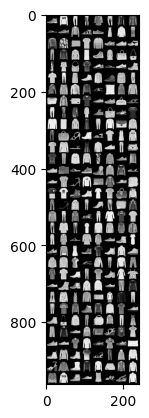

torch.Size([256])

In [49]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [303]:
# TODO: you will design your model here
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: complete this method
        super(ConvModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=6, kernel_size=(5, 5))
        self.batch_norm = nn.BatchNorm2d(6)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.lin1 = nn.Linear(in_features=6*12*12, out_features=84)
        self.lin2 = nn.Linear(in_features=84, out_features=output_size)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # TODO: complete this method
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.lin2(x)
        x = self.logSoftmax(x)
        
        return x


In [273]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # TODO: implement one epoch of training
    model.train()
    
    loss = np.zeros(len(train_loader))
    correct = np.zeros(len(train_loader))

    i = 0
    for (X, y) in train_loader:
        (X, y) = (X.to(device), y.to(device))
        scores = model(X)
        prediction = torch.argmax(scores, dim=1)

        loss_step = loss_fn(scores, y)
        correct[i] += torch.eq(prediction, y).sum().item()

        model.zero_grad()
        loss_step.backward()
        optimizer.step()

        norms = np.array([np.linalg.norm(param.detach().numpy()) for param in model.parameters()])
        loss[i] = loss_step.detach().numpy() + reg_param * sum(norms)

        if i % 90 == 0:
            print(f"Batch: {i}\tAccuracy: {((correct[i] / 256) * 100):.2f}\tLoss: {loss[i]:.2f}")
        i += 1
    accuracy = sum(correct) / (len(train_loader) * 256) * 100
    return (model, sum(loss), accuracy)

In [301]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # TODO: implement evaluation on a data set, data_loader
    model.eval()
    loss = np.zeros(len(data_loader))
    correct = np.zeros(len(data_loader))
    i = 0
    with torch.inference_mode():
        for (X, y) in data_loader:
            (X, y) = (X.to(device), y.to(device))
            scores = model(X)
            prediction = torch.argmax(scores, dim=1)
    
            loss_step = loss_fn(scores, y)
            correct[i] += torch.eq(prediction, y).sum().item()

            model.zero_grad()

            norms = np.array([np.linalg.norm(param.detach().numpy()) for param in model.parameters()])
            loss[i] = loss_step.detach().numpy() + reg_param * sum(norms)

            i += 1        
    accuracy = (sum(correct) / (len(data_loader) * 256)) * 100
    print(f"Accuracy: {accuracy}\tLoss: {sum(loss)}")
    return (model, sum(loss), accuracy)

In [306]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # TODO: write codes to train your model here
    input_size = 1
    output_size = 10
    
    n_epochs = 1000

    model = ConvModel(input_size, output_size)
    loss_fn = nn.CrossEntropyLoss()
    lr = 0.05
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    reg_param = 0.4

    train_loss = np.zeros(n_epochs)
    test_loss = np.zeros(n_epochs)
    validation_loss = np.zeros(n_epochs)
    train_accuracy = np.zeros(n_epochs)
    test_accuracy = np.zeros(n_epochs)
    validation_accuracy = np.zeros(n_epochs)

    for i in np.arange(n_epochs):
        print(f"Epoch {i}")
        print("Train: ")
        model, train_accuracy[i], train_loss[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        print("Validation: ")
        model, validation_accuracy[i], validation_loss[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        print("Test: ")
        model, test_accuracy[i], test_loss[i] = evaluation_step(model, test_loader, loss_fn, reg_param, device)

    return model, train_loss, train_accuracy, validation_loss, validation_accuracy, test_loss, test_accuracy

In [299]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
   # TODO: plot accuracy curves, you can reuse your codes from the simple classification task

SyntaxError: incomplete input (254378377.py, line 2)

In [282]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
# TODO: plot loss curves, you can reuse your codes from the simple classification task

SyntaxError: incomplete input (771524813.py, line 2)

In [307]:
# Do not change this cell
random_seed = 1
(
    model,
    train_losses,
    train_accuracies,
    valid_losses,
    valid_accuracies,
    test_losses,
    test_accuracies,
) = train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 0
Train: 
Batch: 0	Accuracy: 14.84	Loss: 6.97
Batch: 90	Accuracy: 79.30	Loss: 5.83
Batch: 180	Accuracy: 84.77	Loss: 5.93
Validation: 
Accuracy: 82.64627659574468	Loss: 280.4419246733188
Test: 
Accuracy: 80.1171875	Loss: 239.08494669198976
Epoch 1
Train: 
Batch: 0	Accuracy: 83.98	Loss: 5.91
Batch: 90	Accuracy: 82.81	Loss: 6.12
Batch: 180	Accuracy: 84.38	Loss: 6.14
Validation: 
Accuracy: 85.33909574468085	Loss: 289.01442603468894
Test: 
Accuracy: 82.75390625	Loss: 246.69606472551808
Epoch 2
Train: 
Batch: 0	Accuracy: 85.16	Loss: 6.16
Batch: 90	Accuracy: 80.47	Loss: 6.32
Batch: 180	Accuracy: 84.38	Loss: 6.31
Validation: 
Accuracy: 87.00132978723404	Loss: 295.5604994088409
Test: 
Accuracy: 84.501953125	Loss: 252.38126233220083
Epoch 3
Train: 
Batch: 0	Accuracy: 85.94	Loss: 6.32
Batch: 90	Accuracy: 87.89	Loss: 6.31
Batch: 180	Accuracy: 87.11	Loss: 6.47
Validation: 
Accuracy: 86.08710106382979	Loss: 303.073498415947
Test: 
Accuracy: 83.623046875	Loss: 258.87196364998834
Epoch 4
Train: 

KeyboardInterrupt: 

In [ ]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)

In [ ]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

In [ ]:
n_validations = 10
    n_epochs = 10

    loss_fn = nn.CrossEntropyLoss()
    train_accuracy = np.empty(0)
    train_loss = np.empty(0)
    validation_accuracy = np.empty(0)
    validation_loss = np.empty(0)
    test_accuracy = np.empty(0)
    test_loss = np.empty(0)

    
    conv1out_range = np.arange(2, 12, 2)
    conv2out_range = np.arange(8, 24, 2)
    linout_range = np.arange(4, 16, 2)
    lr_range = np.linspace(0.001, .05, 20)
    reg_param_range = np.linspace(0, 1, 20)
    input_size = 1
    output_size = 10

    param_grid = {
        "conv1out": conv1out_range,
        "conv2out": conv2out_range,
        "linout": linout_range,
        "lr": lr_range,
        "reg_param": reg_param_range
    }
    
    conv1out_accuracies = np.zeros(len(conv1out_range))
    conv2out_accuracies = np.zeros(len(conv2out_range))
    linout_accuracies = np.zeros(len(linout_range))
    lr_accuracies = np.zeros(len(lr_range))
    reg_param_accuracies = np.zeros(len(reg_param_range))

    j = 0
    for reg_param in reg_param_range:
        train_accuracies = np.zeros(n_epochs)
        train_losses = np.zeros(n_epochs)
        validation_accuracies = np.zeros(n_epochs)
        validation_losses = np.zeros(n_epochs)
        
        model = ConvModel(input_size, output_size).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

        for i in np.arange(n_epochs):
            model, train_accuracies[i], train_losses[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
            model, validation_accuracies[i], validation_losses[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        train_accuracy = np.append(train_accuracy, train_accuracies)
        validation_accuracy = np.append(validation_accuracy, validation_accuracies)
        train_loss = np.append(train_loss, train_losses)
        validation_loss = np.append(validation_loss, validation_losses)

        reg_param_accuracies[j] = validation_accuracies
        j += 1
        
    reg_param = reg_param_range[np.argmax(reg_param_accuracies, dim=1)]
    print("Tuned Reg Param")

    j = 0
    for lr in lr_range:
        train_accuracies = np.zeros(n_epochs)
        train_losses = np.zeros(n_epochs)
        validation_accuracies = np.zeros(n_epochs)
        validation_losses = np.zeros(n_epochs)
        
        model = ConvModel(input_size, output_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        for i in np.arange(n_epochs):
            model, train_accuracies[i], train_losses[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
            model, validation_accuracies[i], validation_losses[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        train_accuracy = np.append(train_accuracy, train_accuracies)
        validation_accuracy = np.append(validation_accuracy, validation_accuracies)
        train_loss = np.append(train_loss, train_losses)
        validation_loss = np.append(validation_loss, validation_losses)

        lr_accuracies[j] = validation_accuracies
        j += 1

    lr_pick = lr_range[np.argmax(lr_accuracies)]
    print("Tuned Learning Rate")
    
    j = 0
    for conv1out in conv1out_range:
        print("j")
        train_accuracies = np.zeros(n_epochs)
        train_losses = np.zeros(n_epochs)
        validation_accuracies = np.zeros(n_epochs)
        validation_losses = np.zeros(n_epochs)
        
        model = ConvModel(input_size, output_size, conv1out=conv1out)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_pick)

        for i in np.arange(n_epochs):
            model, train_accuracies[i], train_losses[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
            model, validation_accuracies[i], validation_losses[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        train_accuracy = np.append(train_accuracy, train_accuracies)
        validation_accuracy = np.append(validation_accuracy, validation_accuracies)
        train_loss = np.append(train_loss, train_losses)
        validation_loss = np.append(validation_loss, validation_losses)

        conv1out_accuracies[j] = validation_accuracies
        j += 1
        
    conv1out_pick = conv1out_range[np.argmax(conv1out_accuracies, dim=1)]
    print("Tuned conv1out")
    
    j = 0
    for conv2out in conv2out_range:
        train_accuracies = np.zeros(n_epochs)
        train_losses = np.zeros(n_epochs)
        validation_accuracies = np.zeros(n_epochs)
        validation_losses = np.zeros(n_epochs)
        
        model = ConvModel(input_size, output_size, conv1out=conv1out_pick, conv2out=conv2out)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_pick)
        for i in np.arange(n_epochs):
            model, train_accuracies[i], train_losses[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
            model, validation_accuracies[i], validation_losses[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        train_accuracy = np.append(train_accuracy, train_accuracies)
        validation_accuracy = np.append(validation_accuracy, validation_accuracies)
        train_loss = np.append(train_loss, train_losses)
        validation_loss = np.append(validation_loss, validation_losses)

        conv2out_accuracies[j] = validation_accuracies
        j += 1

    conv2out_pick = conv2out_range[np.argmax(conv2out_accuracies, dim=1)]
    print("Tuned conv2out")
    
    j = 0
    for linout in linout_range:
        train_accuracies = np.zeros(n_epochs)
        train_losses = np.zeros(n_epochs)
        validation_accuracies = np.zeros(n_epochs)
        validation_losses = np.zeros(n_epochs)
        
        model = ConvModel(input_size, output_size, conv1out=conv1out_pick, conv2out=conv2out_pick, linout=linout)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_pick)
        for i in np.arange(n_epochs):
            model, train_accuracies[i], train_losses[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
            model, validation_accuracies[i], validation_losses[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        train_accuracy = np.append(train_accuracy, train_accuracies)
        validation_accuracy = np.append(validation_accuracy, validation_accuracies)
        train_loss = np.append(train_loss, train_losses)
        validation_loss = np.append(validation_loss, validation_losses)

        linout_accuracies[j] = validation_accuracies
        j += 1
        
    linout_pick = linout_range[np.argmax(linout_accuracies, dim=1)]
    print("Finished tuning")

    model = ConvModel(input_size, output_size, conv1out=conv1out_pick, conv2out=conv2out_pick, linout=linout_pick)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_pick)

    train_accuracy_best = np.zeros(n_epochs)
    validation_accuracy_best = np.zeros(n_epochs)
    test_accuracy_best = np.zeros(n_epochs)
    train_loss_best = np.zeros(n_epochs)
    validation_loss_best = np.zeros(n_epochs)
    test_loss_best = np.zeros(n_epochs)
    
    for i in np.arange(n_epochs):
        model, train_accuracy_best[i], train_loss_best[i] = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        model, validation_accuracy_best[i], validation_loss_best[i] = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        model, test_accuracy_best[i], test_loss_best[i] = evaluation_step(model, test_loader, loss_fn, reg_param, device)

    return model, train_loss_best, train_accuracy_best, validation_loss_best, validation_accuracy_best, test_loss_best, test_accuracy_best